In [1]:
import os
import csv
import cv2
import numpy as np
import sklearn

import matplotlib.pyplot as plt

from time import gmtime, strftime
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Lambda, Flatten, Dense, Cropping2D
from keras.layers.convolutional import Convolution2D

Using TensorFlow backend.


In [2]:
CSV_PATH = "./data/driving_log.csv"
IMG_DIR_PATH = "./data/IMG/"

In [3]:
samples = []
with open(CSV_PATH) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

samples = samples[1:] # Exclude line with labels

## With generator

In [4]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [6]:
EPOCHS = 5
CORRECTION = 0.2

In [7]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = IMG_DIR_PATH+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                # Flipped image
                images.append(np.fliplr(center_image))
                angles.append(center_angle * -1.0)
                # Left image
                left_image_path = IMG_DIR_PATH+batch_sample[1].split('/')[-1]
                left_image = cv2.imread(left_image_path)
                images.append(left_image)
                angles.append(center_angle + CORRECTION)
                # Right image
                right_image_path = IMG_DIR_PATH+batch_sample[2].split('/')[-1]
                right_image = cv2.imread(right_image_path)
                images.append(right_image)
                angles.append(center_angle - CORRECTION)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

In [8]:
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

## Network architecture

In [10]:
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (160, 320 ,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5,subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5,subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(20))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [11]:
history_object = model.fit_generator(train_generator, samples_per_epoch= 4*len(train_samples), validation_data=validation_generator, nb_val_samples=4*len(validation_samples), nb_epoch=EPOCHS)

Epoch 1/5
25712/25712 [==============================] - 56s - loss: 0.0186 - val_loss: 0.0147
Epoch 2/5
25712/25712 [==============================] - 52s - loss: 0.0155 - val_loss: 0.0134
Epoch 3/5
25712/25712 [==============================] - 52s - loss: 0.0144 - val_loss: 0.0129
Epoch 4/5
25712/25712 [==============================] - 52s - loss: 0.0137 - val_loss: 0.0129
Epoch 5/5
25712/25712 [==============================] - 52s - loss: 0.0129 - val_loss: 0.0128


### Save the file

In [12]:
postfix = "NVIDIA"
curtime = strftime("%Y-%m-%d-%H-%M-", gmtime())
model.save('model-' + curtime + postfix + '.h5')

## Visualizing loss for each epoch

dict_keys(['loss', 'val_loss'])


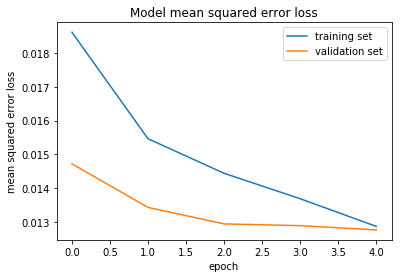

In [13]:
print(history_object.history.keys())
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()